In [2]:

import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import scipy.io as io
import copy
import metpy as mtp
from scipy import integrate
import xesmf as xe
import cartopy.crs as ccrs

In [58]:

import xarray as xr
import numpy as np
import ERA5_functions as era_fncts
import time as time_it
from glob import glob
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [11]:
#Constants
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007  

In [55]:
#new_weight = era_fncts.aht_weights()

#np.save('aht_calcs/aht_weights.npy', new_weight)

/home/disk/p/tylersc/anaconda3/envs/era5/lib/python3.9/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [28]:
#Want to get a weighting function to take zonal means like Aarons ZON_NORM

zonal_sum = np.nansum(new_weight, axis=2)

zon_norm = new_weight/zonal_sum[:,:,None]

zon_norm[np.isnan(zon_norm)] = 0
#np.save('zonal_norms', zon_norm)

In [7]:
new_weight_zonal_ave = np.nanmean(new_weight, axis=2)
    
#Now make sure we don't count nan levels in zonal mean
nan_count=np.isnan(new_weight).sum(axis=2)
nan_count=1-(nan_count/len(new_weight[0,0,:]))
new_weight_zonal_ave=new_weight_zonal_ave*nan_count

In [8]:
aaron_weight = io.loadmat('aaron_aht_stuff/CLIM_MASKS.mat', verify_compressed_data_integrity=False)
aaron_ps = io.loadmat('aaron_aht_stuff/CLIM_PS_all_years.mat', verify_compressed_data_integrity=False)

In [23]:
print(aaron_weight.keys())

dict_keys(['__header__', '__version__', '__globals__', 'CPS', 'TMASK', 'WEIGHT', 'WEIGHT2', 'ZON_NORM', 'ZON_NORM2', 'ZON_WEIGHT', 'ZON_WEIGHT2', 'lat', 'lev', 'lon'])


In [9]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]



<ipython-input-22-fa100fca62ed>:9: RuntimeWarning: Mean of empty slice
  plt.contourf(lats, levels, np.nanmean(new_weight, axis=2)/g)


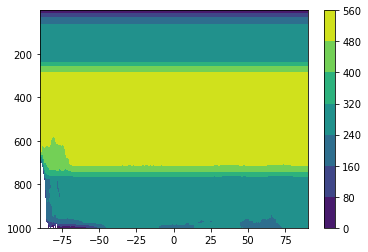

Text(0.5, 1.0, 'Zonally averaged weights')

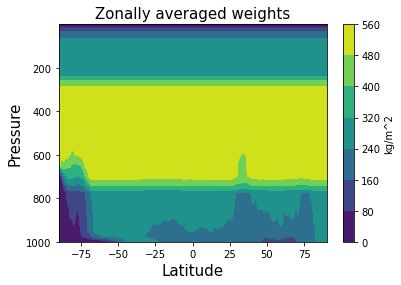

In [22]:
aaron_weight_zonal_array = aaron_weight['ZON_WEIGHT']
#aaron_weight_zonal_array[aaron_weight_zonal_array==0] = np.nan
aaron_zon_norm = aaron_weight['ZON_NORM']
      
      
#plt.contourf(lats, levels, aaron_weight_zonal_array * np.nansum(aaron_zon_norm, axis=2))
#plt.contourf(lats, levels, np.nansum(aaron_zon_norm, axis=2))

plt.contourf(lats, levels, np.nanmean(new_weight, axis=2)/g)
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

plt.contourf(lats, levels, aaron_weight_zonal_array)

plt.gca().invert_yaxis()

#plt.contourf(lons, lats, np.nansum(new_weight/g - aaron_weight['WEIGHT'], axis=0))

plt.colorbar(label='kg/m^2')
plt.xlabel('Latitude', fontsize=15)
plt.ylabel('Pressure', fontsize=15)
plt.title('Zonally averaged weights', fontsize=15)

#plt.savefig('../Research_meetings/7_14_21/zonally_ave_aht_weight')

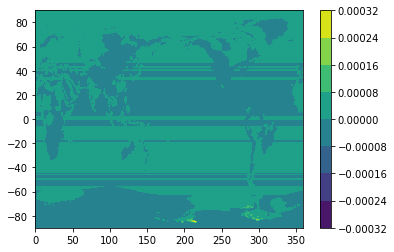

In [37]:
plt.contourf(lons, lats, (zon_norm - aaron_zon_norm)[35,:,:])
plt.colorbar()

In [63]:
year = 1979

times ='00'

time_idx = 150

vcomp, temp, sphum, geo_pot = era_fncts.aht_opener_helper(year, times)

new_ds = era_fncts.aht_instant3(era_fncts.aht_time_sel_helper(vcomp, temp, sphum, geo_pot, time_idx), new_weight)

other_ds = era_fncts.aht_instant4(era_fncts.aht_time_sel_helper(vcomp, temp, sphum, geo_pot, time_idx), new_weight)

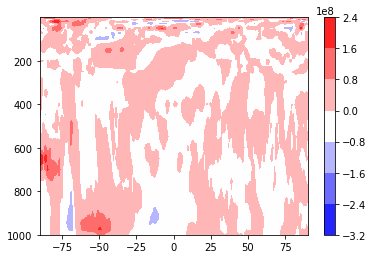

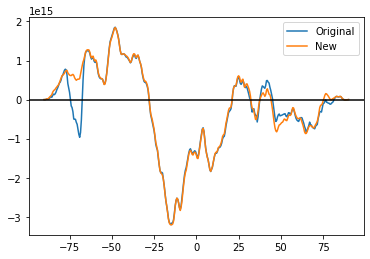

In [64]:
mmc_tot = new_ds.mmc_tot_int.sum(['level'], skipna=True).values
mmc_tot_other = other_ds.mmc_tot_int.sum(['level'], skipna=True).values
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

plt.contourf(lats, levels, new_ds.mmc_tot_int,  cmap='bwr')

plt.colorbar()
plt.gca().invert_yaxis()

plt.show()


plt.plot(lats, mmc_tot * geometry, label='Original')
plt.plot(lats, mmc_tot_other * geometry, label='New')
#plt.plot(lats, (mmc_tot- mmc_tot_other) * geometry, label='Diff')
plt.axhline(0, color='k')

plt.legend(loc=0)

In [13]:
#load in the surface pressure
ps = xr.open_dataset('monthly_ps.nc')

    
#Load in the era5 data to get the proper lat/lon and levels
dummy_era5_data = xr.open_dataset('/home/disk/eos9/ERA5/hourly_pl/00/1985.v.nc')
    
lat = dummy_era5_data.latitude
lon = dummy_era5_data.longitude
    
new_coords = xr.Dataset({'lat': (['lat'], dummy_era5_data.latitude.values),
                        'lon': (['lon'], dummy_era5_data.longitude.values),
                    }
                    )

grid_in = {'lon': ps.longitude.values,
           'lat': ps.latitude.values
          }

# output grid has a larger coverage and finer resolution
grid_out = {'lon': dummy_era5_data.longitude.values,
            'lat': dummy_era5_data.latitude.values
           }

regridder = xe.Regridder(grid_in, grid_out, 'bilinear')
#regridder = xe.Regridder(ps, new_coords, 'conservative')

    # the entire dataset can be processed at once
new_ps = regridder(ps)
    
ps_all=new_ps.sp.mean(['time']).sel(expver=1) #Surface pressure


/home/disk/p/tylersc/anaconda3/envs/era5/lib/python3.9/site-packages/xesmf/frontend.py:531: UserWarning: Using dimensions ('latitude', 'longitude') from data variable sp as the horizontal dimensions for the regridding.
  warnings.warn(
/home/disk/p/tylersc/anaconda3/envs/era5/lib/python3.9/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [14]:
ps_part = new_ps.sp.sel(time=slice('2001', '2018')).mean(['time']).sel(expver=1) #Surface pressure

In [ ]:
plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

plt.contourf(lons, lats, aaron_ps['CPS'])
#plt.contourf(lons, lats, ps_part)

plt.colorbar(label='Pa')
#print(aaron_ps.keys())

In [148]:
#np.save('aht_calcs/aht_weights.npy', new_weight)